This notebook is used to train and evaluate our model. We train a Cox proportional hazards model that stratifies populations by age. We then analyze the results by (1)computing hazard ratios and (2) generating survival functions, which we compare to Kaplan-Meier survival functions.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from src.features.cleaning import clean_data, split_X_and_y_data
from src.utils import get_project_root

In [3]:
dir_root = get_project_root()
dir_data = 'data'
filename_data_brain = os.path.join(
    dir_root,
    dir_data, 
    'survival_brain_2000_to_2020_seer_2022_db.csv'
)
data_raw = pd.read_csv(filename_data_brain)

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_31664/801828396.py:8: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv(filename_data_brain)


In [4]:
data = clean_data(data_raw)

## Train-Test Split

In [5]:
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import SelectKBest
from scipy import stats

In [6]:
# Train-test split
data_train, data_test = train_test_split(
    data, 
    test_size=0.2, 
    random_state=2984, 
    shuffle=True, 
    stratify=data['Vital status recode (study cutoff used)']
)

X_train, y_train = split_X_and_y_data(data_train)
X_test , y_test  = split_X_and_y_data(data_test)

## Kaplan-Meier Curve

We can train a Kaplan-Meier estimator:

In [7]:
from lifelines import KaplanMeierFitter

In [8]:
kmf = KaplanMeierFitter()
kmf.fit(y_train['Survival months'], event_observed=y_train['Event indicator'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 59465 total observations, 14271 right-censored observations>

Text(0.5, 0, 'Months from diagnosis')

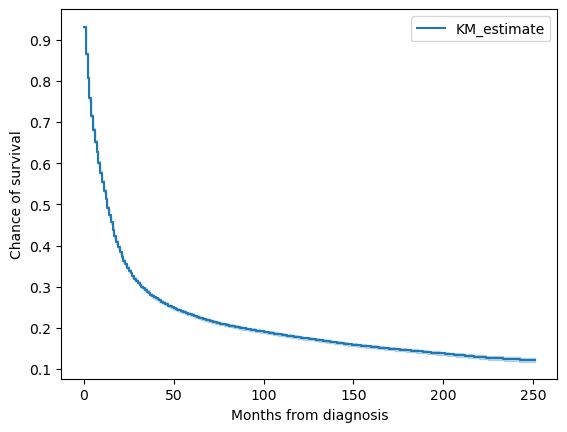

In [9]:
ax = kmf.plot_survival_function()
ax.set_ylabel('Chance of survival')
ax.set_xlabel('Months from diagnosis')

### K-M with multiple groups

In [10]:
def plot_km_curve(X, y, stratify_class=None, ax=None) -> plt.Axes:
    '''
    Plots the Kaplan-Meier curve for the data, optionally splitting the data 
    into separate classes based on one of the columns.
    '''
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    kmf = KaplanMeierFitter()
    if stratify_class is None:
        kmf.fit(
            y['Survival months'], 
            event_observed=y['Event indicator']
        )
        kmf.plot_survival_function(ax=ax)
        ax.set_title('K-M curve')
    else:
        for name, grouped_df in X.join(y).groupby(stratify_class):
            kmf.fit(
                grouped_df["Survival months"], 
                grouped_df["Event indicator"], 
                label=name
            )
            kmf.plot_survival_function(ax=ax)
            ax.set_title(f'K-M curve for values of "{stratify_class}"')
    ax.set_ylabel('Chance of survival')
    ax.set_xlabel('Months from diagnosis')
    return ax

In [11]:
def manually_set_legend_labels(ax: plt.Axes, new_labels: tuple[str]):
    legend_texts = ax.legend().get_texts()
    if len(legend_texts) != len(new_labels):
        raise ValueError(
            'new_labels must contain the same number of entries as the legend.')
    
    for text_old, label_new in zip(legend_texts, new_labels):
        text_old.set_text(label_new)
        
def manually_set_line_colors(ax: plt.Axes, new_colors: tuple[str]):
    lines = ax.get_lines()
    if len(lines) != len(new_colors):
        raise ValueError(
            'new_colors must contain the same number of entries as the lines.')
    
    for line, color_new in zip(lines, new_colors):
        line.set_color(color_new)

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_31664/1427744031.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in X.join(y).groupby(stratify_class):


<Axes: title={'center': 'K-M curve for values of "Sex"'}, xlabel='Months from diagnosis', ylabel='Chance of survival'>

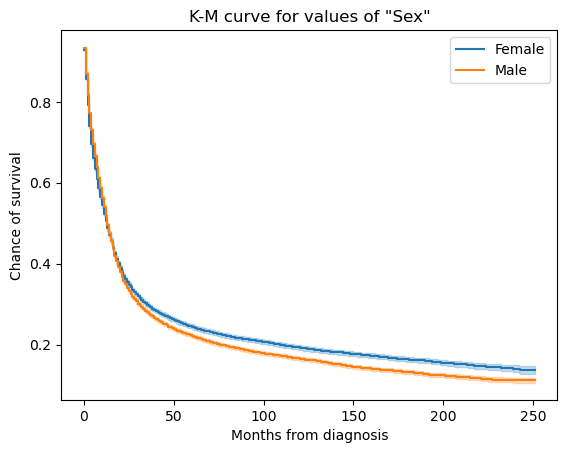

In [12]:
plot_km_curve(X_train, y_train, stratify_class='Sex')

/var/folders/x7/y98cqsdn699czxl0ksdv4x100000gn/T/ipykernel_31664/1427744031.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, grouped_df in X.join(y).groupby(stratify_class):


<Axes: title={'center': 'K-M curve for values of "Race recode (W, B, AI, API)"'}, xlabel='Months from diagnosis', ylabel='Chance of survival'>

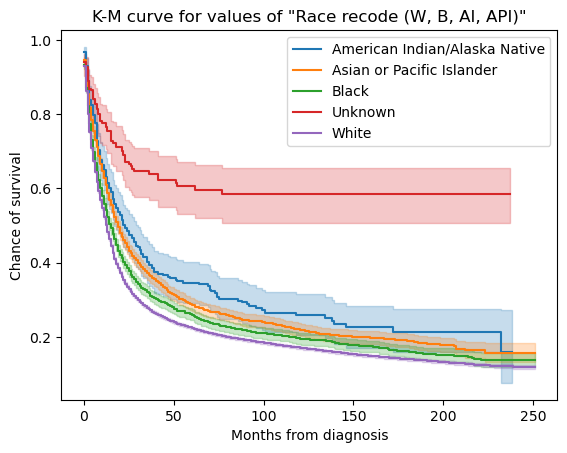

In [13]:
plot_km_curve(X_train, y_train, stratify_class='Race recode (W, B, AI, API)')

## Cox Proportional Hazards Model

In [14]:
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from src.transformers.transformers import DataFrameTransformer, DropCollinearFeatures
from src.models.io import save_model, load_model
from src.models.gridsearch import (
    kfold_cv_train_grid,
    get_best_params_from_kfold_results,
    save_gridsearch_results,
    load_gridsearch_results,
)


def get_model_sorted_coefs(model: CoxPHFitter) -> pd.DataFrame:
    return model.summary.sort_values("coef", key=abs, ascending=False)


def plot_model_sorted_coefs(model: CoxPHFitter, n_top_coefs: int = 20) -> plt.Figure:
    model_sorted = get_model_sorted_coefs(model)
    fig, ax = plt.subplots(figsize=(6, n_top_coefs // 2))
    model_sorted["coef"][:n_top_coefs][::-1].plot.barh(ax=ax, legend=False)
    ax.set_xlabel("coefficient")
    ax.grid(True)
    return fig

### Model training

**Technical notes:**
- To prevent `ConvergenceWarning` errors during the training below, we added the `DropCollinearFeatures` step to the preprocessing pipeline, which automatically drops the features (after the other preprocessing, such as one-hot encoding) that are highly colinear. We also adjusted the `OneHotEncoder` to `min_frequency=50` in order to drop infrequent features that were causing related issues during training with cross-validation.
  - For reference, the problematic features were "Histologic Type ICD-O-3", "Diagnostic Confirmation", "Histology recode - broad groupings", "SEER Combined Summary Stage 2000 (2004-2017)", and "Brain Molecular Markers (2018+)".
  - See for more info: https://lifelines.readthedocs.io/en/stable/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
- Lowering the `step_size` in the `fit_options` is necessary to avoid numerical issues. If more features are added in the future, it's possible that the `step_size` will need to be adjusted.

#### Training with single tumors only and full age information

In [15]:
# Feature preprocessing
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=False),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)

column_transformer = make_column_transformer(
    (
        StandardScaler(),
        [
            "Age recode with <1 year olds",
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            "Combined Tumor Size",
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            "Histologic Type ICD-O-3",
            "Grade Recode (thru 2017)",
            "Diagnostic Confirmation",
            "Histology recode - broad groupings",
            "SEER Combined Summary Stage 2000 (2004-2017)",
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Brain Molecular Markers (2018+)",
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    remainder="drop",
    n_jobs=-1,
)
column_transformer.set_output(transform="pandas")
pipeline = make_pipeline(
    column_transformer,
    DropCollinearFeatures(threshold=0.95, verbose=True),
)

X_train_trans = pipeline.fit_transform(X_train, y=y_train)
dd_trans = X_train_trans.join(y_train)

Columns dropped due to colinearity:
  pipeline-1__Sex_Male
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Asian or Pacific Islander
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Black
  pipeline-1__Histologic Type ICD-O-3_9380
  pipeline-1__Histologic Type ICD-O-3_9382
  pipeline-1__Histologic Type ICD-O-3_9385
  pipeline-1__Histologic Type ICD-O-3_9440
  pipeline-1__Histologic Type ICD-O-3_9505
  pipeline-1__Histology recode - broad groupings_8000-8009: unspecified neoplasms
  pipeline-1__Histology recode - broad groupings_9380-9489: gliomas
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not applicable: Information not collected for this case
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not documented; Cannot be determined; Not assessed or unknown if assessed
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_missing_value
  pipelin

In [16]:
print(f'Number of features after preprocessing: {len(dd_trans.columns)}')

Number of features after preprocessing: 111


We first perform K-fold cross-validation to determine the optimal hyperparameters.

In [17]:
overwrite_gridsearch = False  # Set to true if you want to update the grid search
filename_gridsearch = "gridsearch.csv"

# Perform the grid search, or load data from file if applicable
path_gridsearch = os.path.join(get_project_root(), "models", filename_gridsearch)
if os.path.isfile(path_gridsearch) and not overwrite_gridsearch:
    print(f"Loading grid search results from file '../models/{filename_gridsearch}'...")
    results = load_gridsearch_results(filename_gridsearch)
else:
    print("Running grid search...")
    results = kfold_cv_train_grid(
        dd_trans,
        grid_penalizer=np.logspace(-4, 2, 7),
        grid_l1_ratio=np.linspace(0.0, 1.0, 5),
        k=3,
        fitter_kwargs=dict(fit_options=dict(step_size=0.5)),
        scoring_method="log_likelihood",
    )
    print(f"Saving grid search results to file '../models/{filename_gridsearch}'...")
    save_gridsearch_results(results, filename_gridsearch, overwrite=overwrite_gridsearch)

# Get the best hyperparameters based on the grid search results
params_best = get_best_params_from_kfold_results(results)

Loading grid search results from file '../models/gridsearch.csv'...

Best params:
  penalizer:  0.001
  l1_ratio:   0.75
  score_mean: -6.635349253100286


We can then train the final model on the full dataset using the hyperparameters obtained above.

In [18]:
overwrite_model = False  # Set to true if you want to update the model
filename_model = "model.pkl"

# Fit the best model, or load from file if applicable
path_model = os.path.join(get_project_root(), "models", filename_model)
if os.path.isfile(path_model) and not overwrite_model:
    print(f"Loading model from file '../models/{filename_model}'...")
    cph_best = load_model(path_model)
else:
    print("Fitting the best model from grid search results...")
    cph_best = CoxPHFitter(penalizer=params_best.penalizer, l1_ratio=params_best.l1_ratio)
    cph_best.fit(dd_trans, duration_col='Survival months', event_col='Event indicator', show_progress=False)
    print(f"Saving model to file '../models/{filename_model}'...")
    save_model(cph_best, path_model, overwrite=overwrite_model)

# Display statistics for the best model
cph_best.print_summary(decimals=3)

Loading model from file '../models/model.pkl'...


<lifelines.CoxPHFitter: fitted with 59465 total observations, 14271 right-censored observations>
             duration col = 'Survival months'
                event col = 'Event indicator'
                penalizer = 0.001
                 l1 ratio = 0.75
      baseline estimation = breslow
   number of observations = 59465
number of events observed = 45194
   partial log-likelihood = -444279.068
         time fit was run = 2024-06-01 04:58:10 UTC

---
                                                                                                                                                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                                                                                                                           
standardscaler__Age recode with <1 year olds                                                                                                       0.717     2.049     0.007           0.704           0.731               2.021               2.078
standardscaler__Year of diagnosis                                                                                                                 -0.090     0.914     0.015          -0.120          -0.061               0.887               0.941
standardscaler__Median household income inflation adj to 2021 (thousands USD)                                                                     -0.055     0.947     0.005          -0.064          -0.046               0.938               0.955
standardscaler__Combined Tumor Size                                                                                                                0.036     1.037     0.004           0.028           0.045               1.028               1.046
standardscaler__Unknown tumor size                                                                                                                 0.019     1.019     0.006           0.008           0.029               1.008               1.030
pipeline-1__Sex_Female                                                                                                                            -0.063     0.939     0.005          -0.073          -0.053               0.930               0.948
pipeline-1__Race recode (W, B, AI, API)_American Indian/Alaska Native                                                                             -0.000     1.000     0.000          -0.000           0.000               1.000               1.000
pipeline-1__Race recode (W, B, AI, API)_Asian or Pacific Islander                                                                                 -0.009     0.991     0.007          -0.022           0.004               0.978               1.004
pipeline-1__Race recode (W, B, AI, API)_Black                                                                                                     -0.000     1.000     0.000          -0.000           0.000               1.000               1.000
pipeline-1__Race recode (W, B, AI, API)_Unknown                                                                                                   -0.024     0.977     0.012          -0.047          -0.000               0.954               1.000
pipeline-1__Race recode (W, B, AI, API)_White                                                                                                      0.008     1.008     0.008          -0.007           0.024               0.993               1.024
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Hispanic (All Races)                                                        0.000     1.000     0.000          -0.001           0.001               0.999               1.001
pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic American Indian/Alaska Native

##### Feature importances

Unsurprisingly, age is the most important covariate. Being older worsens a patient's survival. In fact, it's common in the scientific literature to stratify the analysis by age (which we do below).

The next most important feature is a glioblastoma diagnosis. Glioblastoma has very poor outcomes among brain cancers (and sadly, is the most common variety). A positive diagnosis here is associated with worse survival.

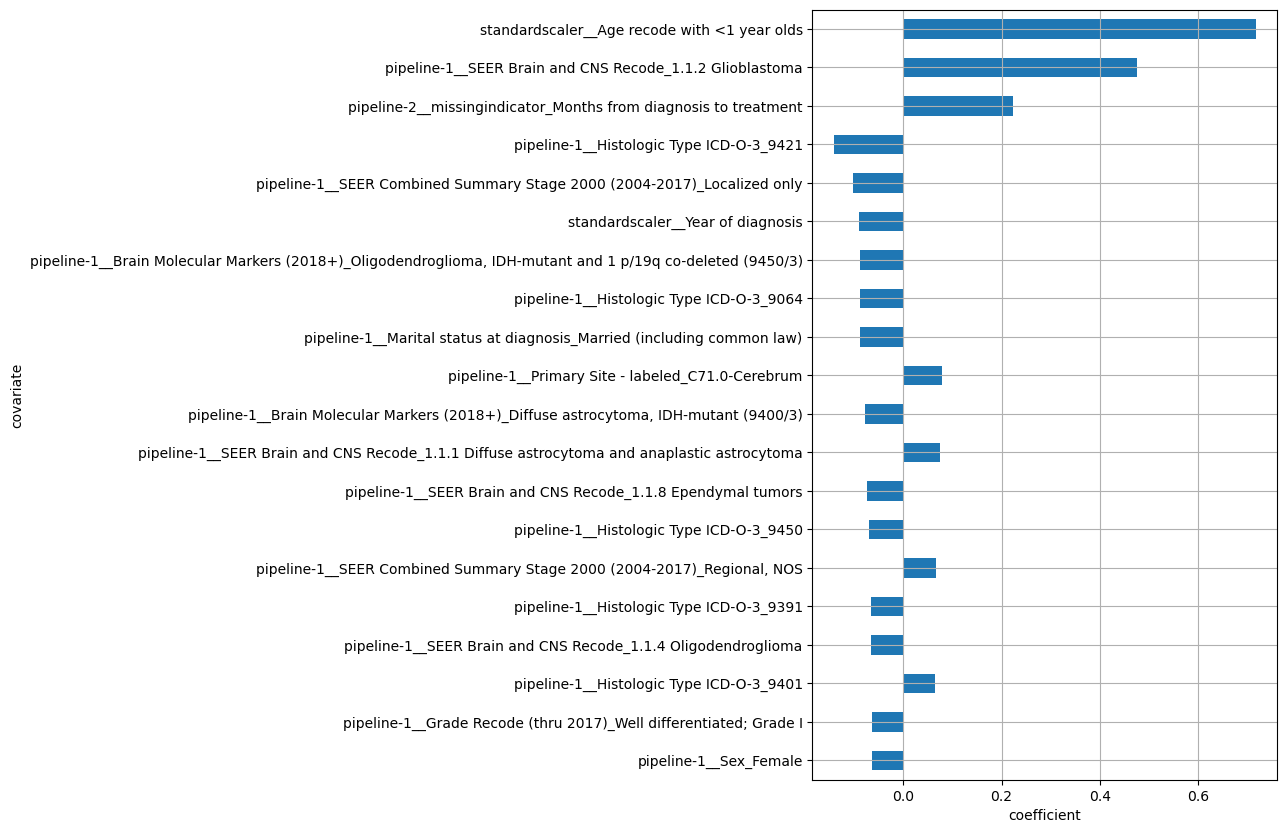

In [19]:
model_sorted = get_model_sorted_coefs(cph_best)
fig = plot_model_sorted_coefs(cph_best)

In [20]:
model_sorted.head(20)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
standardscaler__Age recode with <1 year olds,0.717429,2.049157,0.007075,0.703561,0.731296,2.020937,2.077771,0.0,101.400248,0.000000e+00,inf
pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma,0.475372,1.608612,0.017249,0.441565,0.509179,1.555140,1.663924,0.0,27.560083,3.350596e-167,553.017574
pipeline-2__missingindicator_Months from diagnosis to treatment,0.223542,1.250498,0.006611,0.210585,0.236500,1.234399,1.266807,0.0,33.813070,1.267320e-250,830.140243
pipeline-1__Histologic Type ICD-O-3_9421,-0.141162,0.868349,0.020298,-0.180945,-0.101379,0.834482,0.903591,0.0,-6.954559,3.536664e-12,38.040748
pipeline-1__SEER Combined Summary Stage 2000 (2004-2017)_Localized only,-0.101971,0.903056,0.009797,-0.121173,-0.082770,0.885881,0.920563,0.0,-10.408435,2.269213e-25,81.866010
standardscaler__Year of diagnosis,-0.090449,0.913521,0.015266,-0.120369,-0.060529,0.886593,0.941267,0.0,-5.925009,3.122811e-09,28.254508
"pipeline-1__Brain Molecular Markers (2018+)_Oligodendroglioma, IDH-mutant and 1 p/19q co-deleted (9450/3)",-0.088078,0.915689,0.023012,-0.133181,-0.042975,0.875306,0.957935,0.0,-3.827445,1.294801e-04,12.914983
pipeline-1__Histologic Type ICD-O-3_9064,-0.087744,0.915996,0.014627,-0.116412,-0.059075,0.890108,0.942636,0.0,-5.998734,1.988623e-09,28.905583
pipeline-1__Marital status at diagnosis_Married (including common law),-0.087468,0.916248,0.006860,-0.100913,-0.074023,0.904011,0.928650,0.0,-12.750575,3.094552e-37,121.281609


The hazard ratio gives the increase in risk associated with a unit increase in a given feature. Since the continuous features have been standardized, this represents a 1 standard deviation increase in the feature. Therefore, we have to invert the standardization to be able to interpret these hazard ratios in meaningful terms. Below we calculate the standard deviations for the continuous features:

In [21]:
ct = pipeline.named_steps['columntransformer']
cont_feature_scales = ct.named_transformers_['standardscaler'].scale_
cont_feature_names = ct.named_transformers_['standardscaler'].feature_names_in_
df_cont_feature_scales = pd.DataFrame(cont_feature_scales, index=cont_feature_names, columns=['std'])
print('Continuous feature preprocessing scales:')
df_cont_feature_scales

Continuous feature preprocessing scales:


,std
Age recode with <1 year olds,17.747442
Year of diagnosis,5.949416
Median household income inflation adj to 2021 (thousands USD),11.536780
Combined Tumor Size,37.595165
Unknown tumor size,0.426461


##### Cox model survival functions

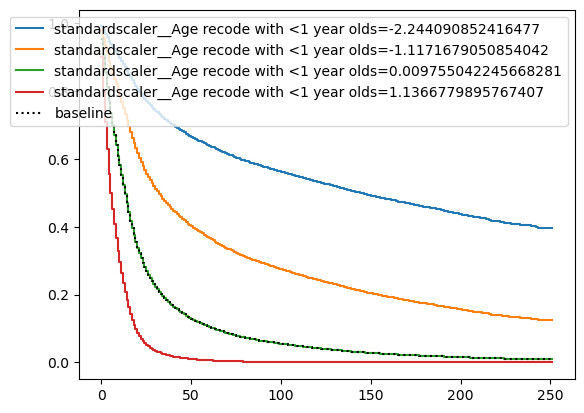

In [22]:
values = np.sort(
    np.unique(dd_trans["standardscaler__Age recode with <1 year olds"].values)
)
plots = cph_best.plot_partial_effects_on_outcome(
    "standardscaler__Age recode with <1 year olds",
    values=values[::4],
    # cmap="coolwarm",
)

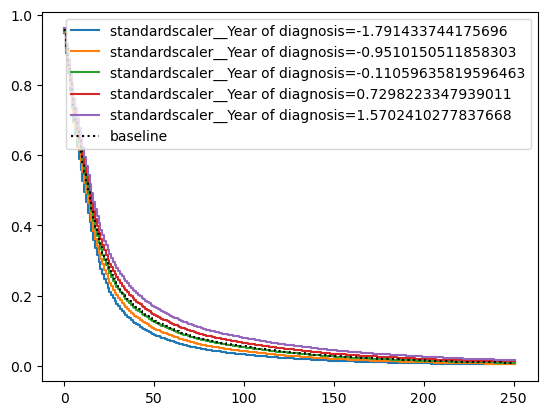

In [23]:
values = np.sort(np.unique(dd_trans["standardscaler__Year of diagnosis"].values))
plots = cph_best.plot_partial_effects_on_outcome(
    "standardscaler__Year of diagnosis",
    values=values[::5],
    # cmap="coolwarm",
)

#### Stratification by age

In [24]:
data = clean_data(data_raw, stratify_age=True)

In [25]:
# Check strata for comparabale bin counts
data["Age standard for survival"].value_counts()

Age standard for survival
15    17886
55    16861
65    15050
75    12448
45    12087
Name: count, dtype: int64

In [26]:
data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=2984,
    shuffle=True,
    stratify=data["Vital status recode (study cutoff used)"],
)

X_train, y_train = split_X_and_y_data(data_train)
X_test, y_test = split_X_and_y_data(data_test)

In [27]:
# Feature preprocessing
impute_ohe_scale = make_pipeline(
    SimpleImputer(strategy="constant", add_indicator=True).set_output(
        transform="pandas"
    ),
    DataFrameTransformer(),
    OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=False),
    StandardScaler(),
)
impute_mean_scale = make_pipeline(
    SimpleImputer(strategy="mean", add_indicator=True), StandardScaler()
)

column_transformer = make_column_transformer(
    ("passthrough", ["Age standard for survival"]),
    (
        StandardScaler(),
        [
            "Year of diagnosis",
            "Median household income inflation adj to 2021 (thousands USD)",
            "Combined Tumor Size",
            "Unknown tumor size",
        ],
    ),
    (
        impute_ohe_scale,
        [
            "Sex",
            "Race recode (W, B, AI, API)",
            "Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)",
            "Marital status at diagnosis",
            "SEER Brain and CNS Recode",
            "Primary Site - labeled",
            "Histologic Type ICD-O-3",
            "Grade Recode (thru 2017)",
            "Diagnostic Confirmation",
            "Histology recode - broad groupings",
            "SEER Combined Summary Stage 2000 (2004-2017)",
            "Chromosome 19q: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)",
            "Brain Molecular Markers (2018+)",
        ],
    ),
    (
        impute_mean_scale,
        [
            "Months from diagnosis to treatment",
        ],
    ),
    remainder="drop",
    n_jobs=-1,
)
column_transformer.set_output(transform="pandas")
pipeline = make_pipeline(
    column_transformer,
    DropCollinearFeatures(threshold=0.95, verbose=True),
)

X_train_trans = pipeline.fit_transform(X_train, y=y_train)
dd_trans = X_train_trans.join(y_train)

Columns dropped due to colinearity:
  pipeline-1__Sex_Male
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Asian or Pacific Islander
  pipeline-1__Race and origin recode (NHW, NHB, NHAIAN, NHAPI, Hispanic)_Non-Hispanic Black
  pipeline-1__Histologic Type ICD-O-3_9380
  pipeline-1__Histologic Type ICD-O-3_9382
  pipeline-1__Histologic Type ICD-O-3_9385
  pipeline-1__Histologic Type ICD-O-3_9440
  pipeline-1__Histologic Type ICD-O-3_9505
  pipeline-1__Histology recode - broad groupings_8000-8009: unspecified neoplasms
  pipeline-1__Histology recode - broad groupings_9380-9489: gliomas
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not applicable: Information not collected for this case
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_Not documented; Cannot be determined; Not assessed or unknown if assessed
  pipeline-1__Chromosome 1p: Loss of Heterozygosity (LOH) Recode (2010+)_missing_value
  pipelin

In [28]:
print(f'Number of features after preprocessing: {len(dd_trans.columns)}')

Number of features after preprocessing: 111


We first perform K-fold cross-validation to determine the optimal hyperparameters.

In [29]:
overwrite_gridsearch = False  # Set to true if you want to update the grid search
filename_gridsearch = "gridsearch_age_stratified.csv"

# Perform the grid search, or load data from file if applicable
path_gridsearch = os.path.join(get_project_root(), "models", filename_gridsearch)
if os.path.isfile(path_gridsearch) and not overwrite_gridsearch:
    print(f"Loading grid search results from file '../models/{filename_gridsearch}'...")
    results = load_gridsearch_results(filename_gridsearch)
else:
    print("Running grid search...")
    results = kfold_cv_train_grid(
        dd_trans,
        grid_penalizer=np.logspace(-4, 2, 7),
        grid_l1_ratio=np.linspace(0.0, 1.0, 5),
        k=3,
        fitter_kwargs=dict(
            fit_options=dict(step_size=0.5),
            strata=["passthrough__Age standard for survival"],
        ),
        scoring_method="log_likelihood",
    )
    print(f"Saving grid search results to file '../models/{filename_gridsearch}'...")
    save_gridsearch_results(results, filename_gridsearch, overwrite=overwrite_gridsearch)

# Get the best hyperparameters based on the grid search results
params_best = get_best_params_from_kfold_results(results)

Loading grid search results from file '../models/gridsearch_age_stratified.csv'...

Best params:
  penalizer:  0.001
  l1_ratio:   0.75
  score_mean: -5.534885774151378


We can then train the final model on the full dataset using the hyperparameters obtained above.

In [30]:
overwrite_model = False  # Set to true if you want to update the model
filename_model = "model_age_stratified.pkl"

# Fit the best model, or load from file if applicable
path_model = os.path.join(get_project_root(), "models", filename_model)
if os.path.isfile(path_model) and not overwrite_model:
    print(f"Loading model from file '../models/{filename_model}'...")
    cph_best = load_model(path_model)
else:
    print("Fitting the best model from grid search results...")
    cph_best = CoxPHFitter(
        penalizer=params_best.penalizer, l1_ratio=params_best.l1_ratio
    )
    cph_best.fit(
        dd_trans,
        duration_col="Survival months",
        event_col="Event indicator",
        show_progress=False,
        strata=["passthrough__Age standard for survival"],
    )
    print(f"Saving model to file '../models/{filename_model}'...")
    save_model(cph_best, path_model, overwrite=overwrite_model)

# Display statistics for the best model
cph_best.print_summary(decimals=3)

Loading model from file '../models/model_age_stratified.pkl'...


model,lifelines.CoxPHFitter
duration col,'Survival months'
event col,'Event indicator'
penalizer,0.001
l1 ratio,0.75
strata,passthrough__Age standard for survival
baseline estimation,breslow
number of observations,59465
number of events observed,45194
partial log-likelihood,-378803.740
time fit was run,2024-06-01 16:47:06 UTC


##### Feature importances

After stratifying by age, the feature importances are generally quite similar to the results above. 

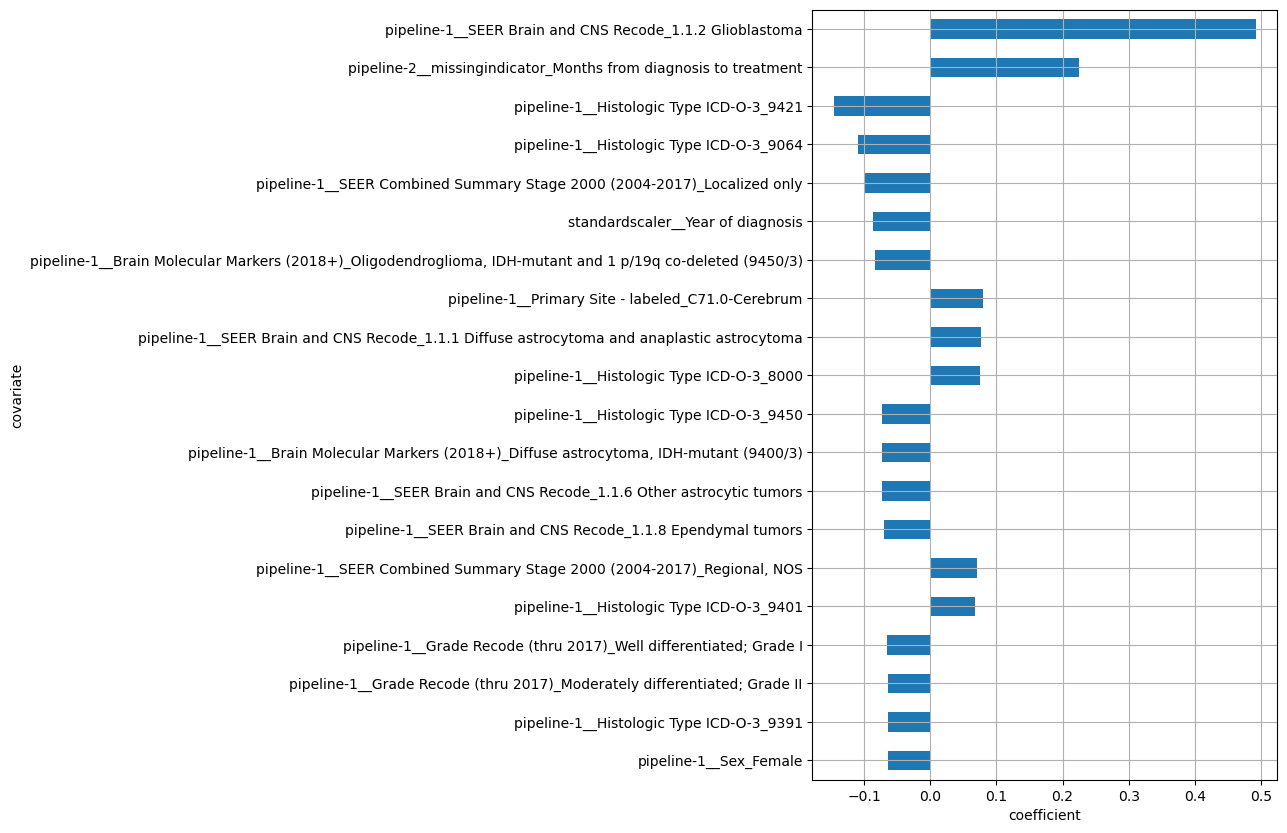

In [31]:
model_sorted = get_model_sorted_coefs(cph_best)
fig = plot_model_sorted_coefs(cph_best)

In [32]:
model_sorted.head(20)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma,0.492484,1.636375,0.017767,0.457660,0.527307,1.580372,1.694363,0.0,27.718457,4.184008e-169,559.340962
pipeline-2__missingindicator_Months from diagnosis to treatment,0.224454,1.251640,0.006616,0.211487,0.237422,1.235514,1.267975,0.0,33.926080,2.748745e-252,835.667107
pipeline-1__Histologic Type ICD-O-3_9421,-0.146005,0.864153,0.020297,-0.185786,-0.106224,0.830451,0.899223,0.0,-7.193531,6.313691e-13,40.526581
pipeline-1__Histologic Type ICD-O-3_9064,-0.108562,0.897123,0.014625,-0.137226,-0.079898,0.871773,0.923211,0.0,-7.423064,1.144417e-13,42.990453
pipeline-1__SEER Combined Summary Stage 2000 (2004-2017)_Localized only,-0.098880,0.905852,0.009793,-0.118074,-0.079685,0.888630,0.923407,0.0,-10.096652,5.716014e-24,77.211265
standardscaler__Year of diagnosis,-0.086932,0.916739,0.015272,-0.116864,-0.057001,0.889706,0.944594,0.0,-5.692432,1.252424e-08,26.250702
"pipeline-1__Brain Molecular Markers (2018+)_Oligodendroglioma, IDH-mutant and 1 p/19q co-deleted (9450/3)",-0.083155,0.920209,0.023019,-0.128271,-0.038039,0.879615,0.962676,0.0,-3.612450,3.033175e-04,11.686883
pipeline-1__Primary Site - labeled_C71.0-Cerebrum,0.080404,1.083725,0.005270,0.070075,0.090733,1.072588,1.094976,0.0,15.256759,1.484396e-52,172.170385
pipeline-1__SEER Brain and CNS Recode_1.1.1 Diffuse astrocytoma and anaplastic astrocytoma,0.076825,1.079853,0.014582,0.048244,0.105406,1.049426,1.111162,0.0,5.268296,1.376960e-07,22.792010


The hazard ratio gives the increase in risk associated with a unit increase in a given feature. Since the continuous features have been standardized, this represents a 1 standard deviation increase in the feature. Therefore, we have to invert the standardization to be able to interpret the hazard ratios in meaningful terms. Below we calculate the standard deviations for the continuous features:

In [33]:
ct = pipeline.named_steps['columntransformer']
cont_feature_scales = ct.named_transformers_['standardscaler'].scale_
cont_feature_names = ct.named_transformers_['standardscaler'].feature_names_in_
df_cont_feature_scales = pd.DataFrame(cont_feature_scales, index=cont_feature_names, columns=['std'])
print('Continuous feature preprocessing scales:')
df_cont_feature_scales

Continuous feature preprocessing scales:


,std
Year of diagnosis,5.949416
Median household income inflation adj to 2021 (thousands USD),11.536780
Combined Tumor Size,37.595165
Unknown tumor size,0.426461


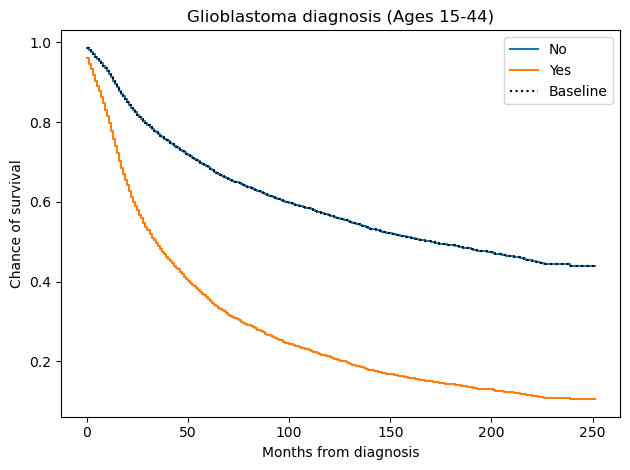

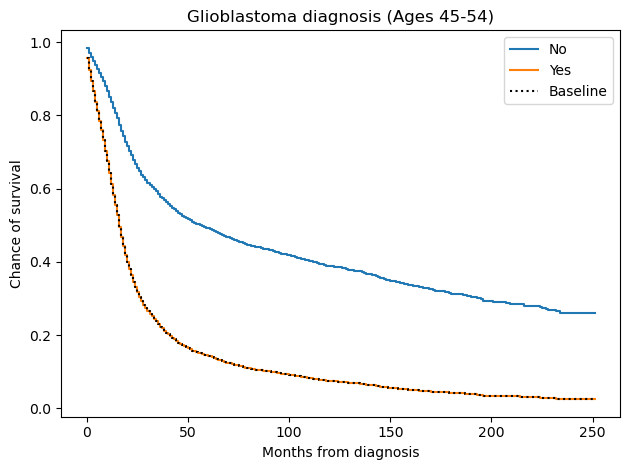

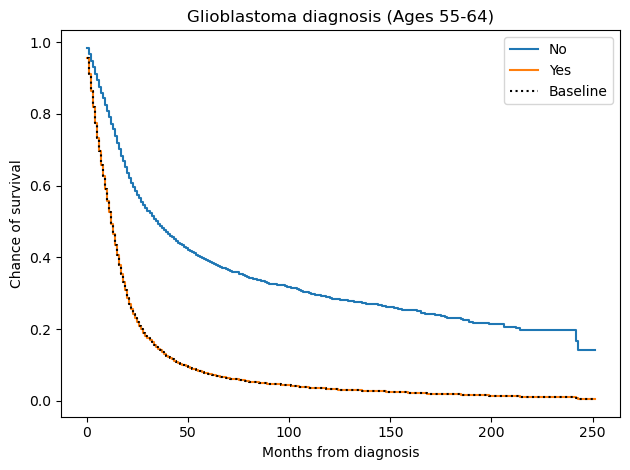

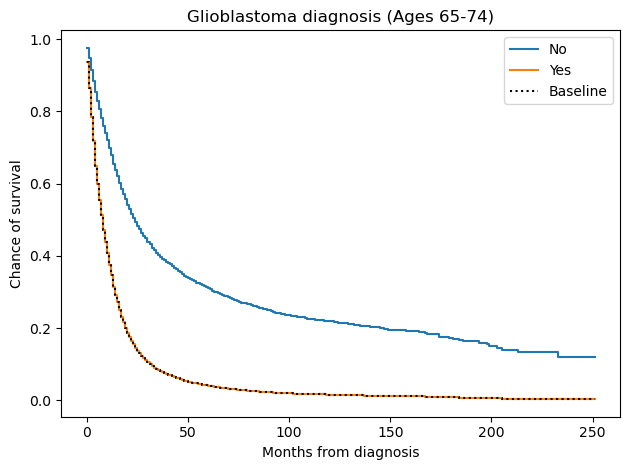

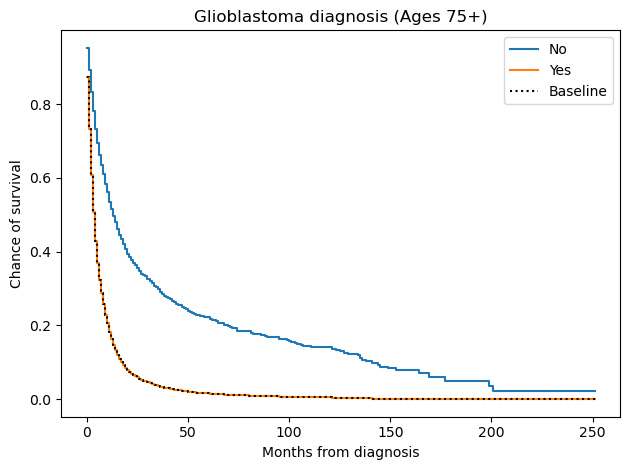

In [34]:
values = np.sort(
    np.unique(
        dd_trans["pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma"].values
    )
)

plots = cph_best.plot_partial_effects_on_outcome(
    "pipeline-1__SEER Brain and CNS Recode_1.1.2 Glioblastoma",
    values=values,
    # cmap="coolwarm",
)
legend_labels = ['No', 'Yes', 'Baseline']
plot_titles = [
    'Glioblastoma diagnosis (Ages 15-44)',
    'Glioblastoma diagnosis (Ages 45-54)',
    'Glioblastoma diagnosis (Ages 55-64)',
    'Glioblastoma diagnosis (Ages 65-74)',
    'Glioblastoma diagnosis (Ages 75+)',
]
colors = ["C0", "C1", "black"]
for i, (plot,title) in enumerate(zip(plots, plot_titles)):
    plot.set_title(title)
    plot.set_xlabel('Months from diagnosis')
    plot.set_ylabel('Chance of survival')
    manually_set_line_colors(plot, colors)
    manually_set_legend_labels(plot, legend_labels)
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig(f'reports/figures/cox_curve_glioblastoma_age_{i}.pdf')

Glioblastoma is rarer in the youngest stratum. This is why the baseline matches the "No" diagnosis in the first plot but matches the "Yes" diagnosis in all of the othr plots.

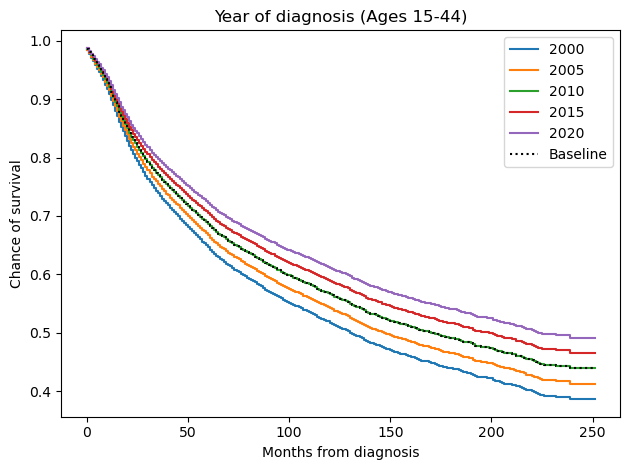

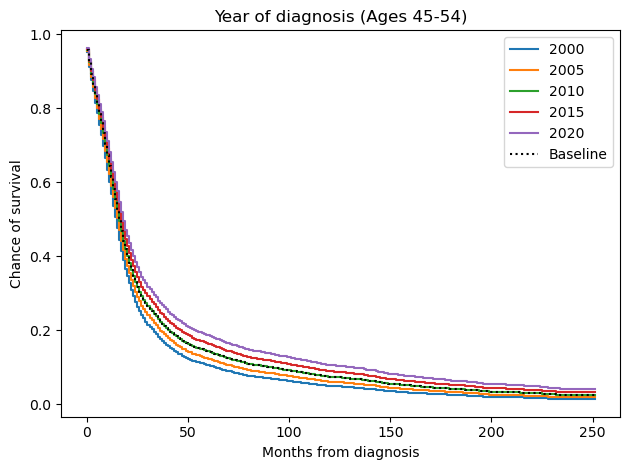

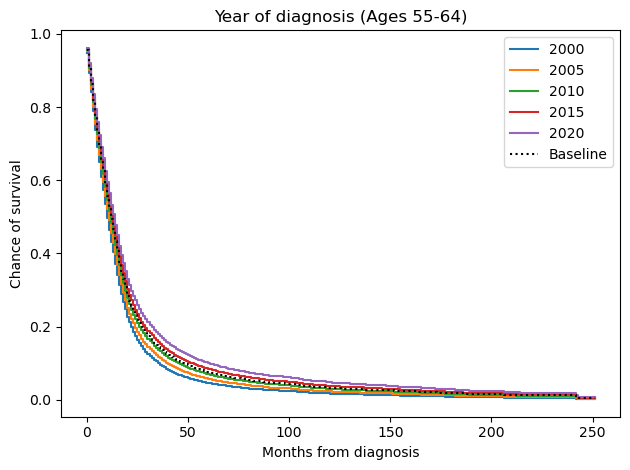

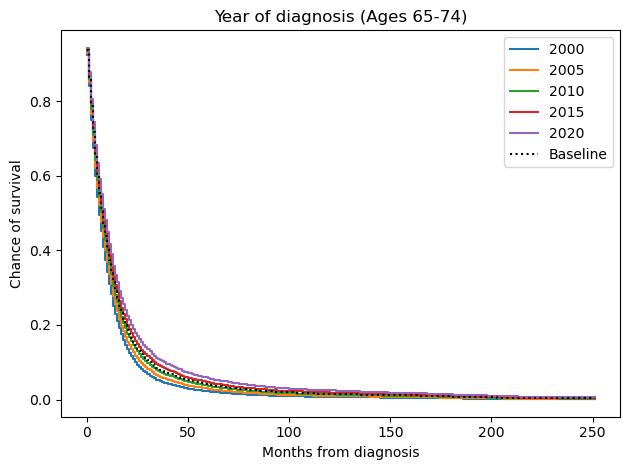

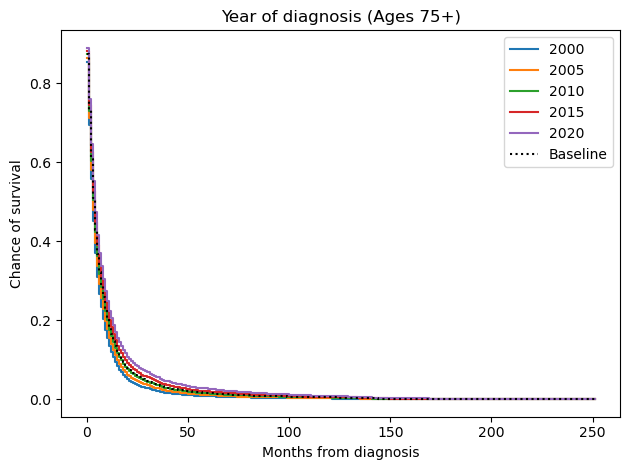

In [35]:
values = np.sort(np.unique(dd_trans["standardscaler__Year of diagnosis"].values))

plots = cph_best.plot_partial_effects_on_outcome(
    "standardscaler__Year of diagnosis",
    values=values[::5],
    # cmap="coolwarm",
)
legend_labels = [str(year) for year in range(2000, 2021, 5)]
legend_labels.append('Baseline')
plot_titles = [
    'Year of diagnosis (Ages 15-44)',
    'Year of diagnosis (Ages 45-54)',
    'Year of diagnosis (Ages 55-64)',
    'Year of diagnosis (Ages 65-74)',
    'Year of diagnosis (Ages 75+)',
]
colors = ["C0", "C1", "C2", "C3", "C4", "black"]
for i, (plot,title) in enumerate(zip(plots, plot_titles)):
    plot.set_title(title)
    plot.set_xlabel('Months from diagnosis')
    plot.set_ylabel('Chance of survival')
    manually_set_line_colors(plot, colors)
    manually_set_legend_labels(plot, legend_labels)
    fig = plot.get_figure()
    fig.tight_layout()
    fig.savefig(f'reports/figures/cox_curve_year_of_diagnosis_age_{i}.pdf')

##### Kaplan-Meier survival function comparison

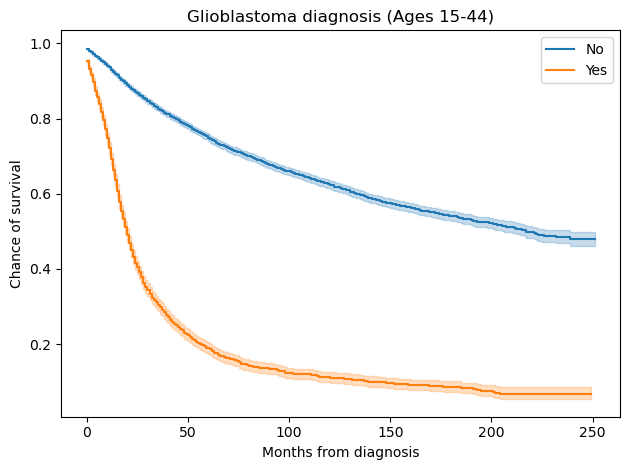

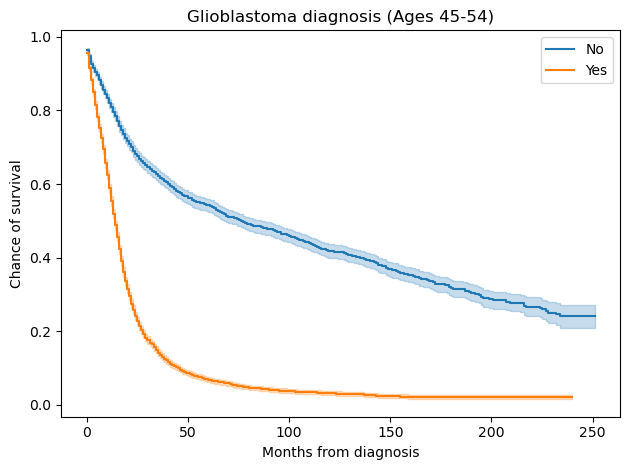

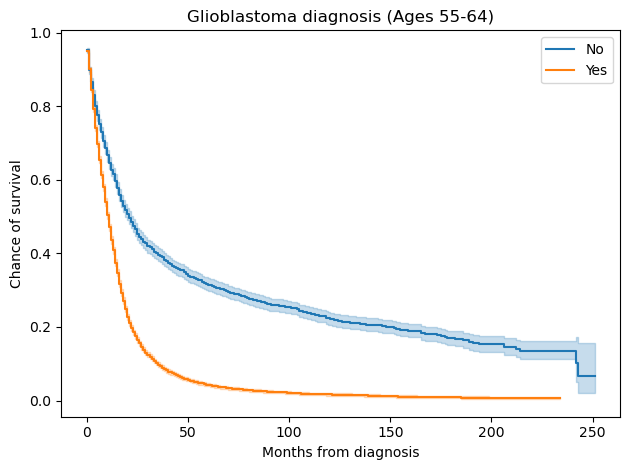

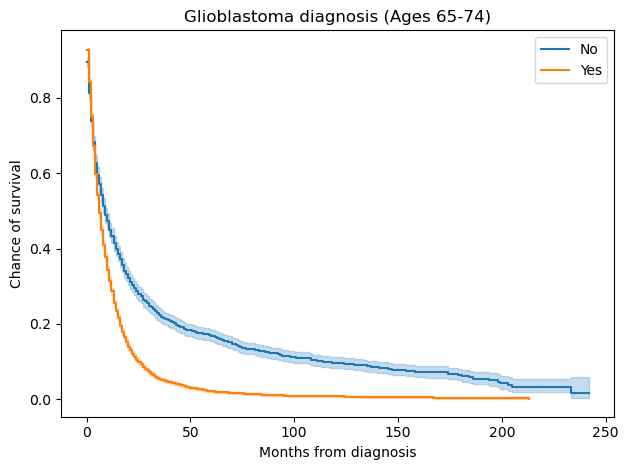

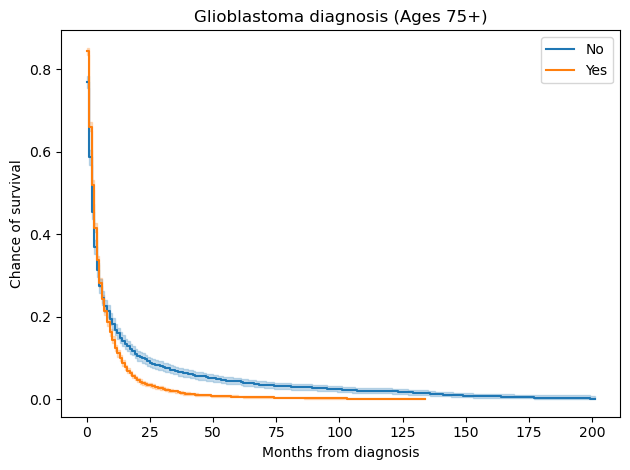

In [36]:
data_copy = data.copy(deep=True)
data_copy['Glioblastoma diagnosis'] = data['SEER Brain and CNS Recode'] == '1.1.2 Glioblastoma'

X_train_copy = X_train.copy(deep=True)
X_train_copy['Glioblastoma diagnosis'] = X_train_copy['SEER Brain and CNS Recode'] == '1.1.2 Glioblastoma'

plot_titles = [
    'Glioblastoma diagnosis (Ages 15-44)',
    'Glioblastoma diagnosis (Ages 45-54)',
    'Glioblastoma diagnosis (Ages 55-64)',
    'Glioblastoma diagnosis (Ages 65-74)',
    'Glioblastoma diagnosis (Ages 75+)',
]
plots = []
for i, (title,(name, grouped_df)) in enumerate(zip(plot_titles,X_train_copy.join(y_train).groupby('Age standard for survival'))):
    grouped_df_gbd_false = grouped_df.query('`Glioblastoma diagnosis` == False')
    grouped_df_gbd_true = grouped_df.query('`Glioblastoma diagnosis` == True')
    
    X_train_grouped_false = grouped_df_gbd_false.drop(["Event indicator", "Survival months"], axis="columns")
    y_train_grouped_false = grouped_df_gbd_false[["Event indicator", "Survival months"]]
    X_train_grouped_true = grouped_df_gbd_true.drop(["Event indicator", "Survival months"], axis="columns")
    y_train_grouped_true = grouped_df_gbd_true[["Event indicator", "Survival months"]]
    
    ax = plot_km_curve(X_train_grouped_false, y_train_grouped_false)
    ax = plot_km_curve(X_train_grouped_true, y_train_grouped_true, ax=ax)
    manually_set_legend_labels(ax, ['No', 'Yes'])
    ax.set_title(title)
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(f'reports/figures/km_curve_glioblastoma_age_{i}.pdf')

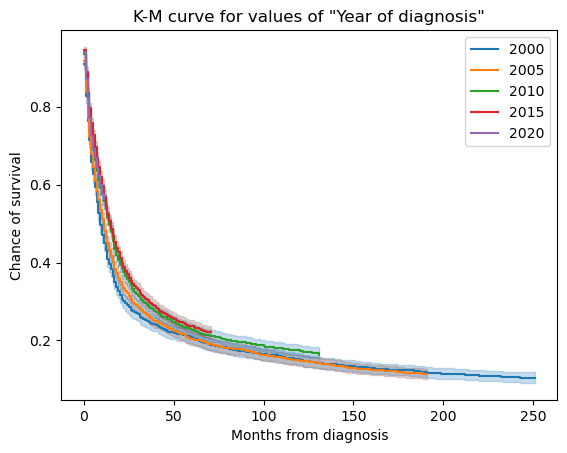

In [37]:
ax = plot_km_curve(X_train, y_train, stratify_class='Year of diagnosis')
labels_to_keep = [str(year) for year in range(2000, 2021, 5)]
tab_colors = plt.get_cmap('tab10').colors

lines = ax.get_lines()
lines_to_keep = [line for line in lines if line.get_label() in labels_to_keep]
for line in lines:
    if line.get_label() not in labels_to_keep:
        line.remove()

collections = ax.collections
collections_to_keep = []
for i, line in enumerate(lines):
    if line.get_label() in labels_to_keep:
        collections_to_keep.append(collections[i])  # Adjust the index for multiple collections per line
for collection in collections:
    if collection not in collections_to_keep:
        collection.remove()
        
for line, color in zip(lines_to_keep, tab_colors):
    line.set_color(color)

ax.legend(handles=lines_to_keep)

In [38]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('reports/figures/km_curve_year_of_diagnosis.pdf')

In [39]:
y_train.columns

Index(['Event indicator', 'Survival months'], dtype='object')

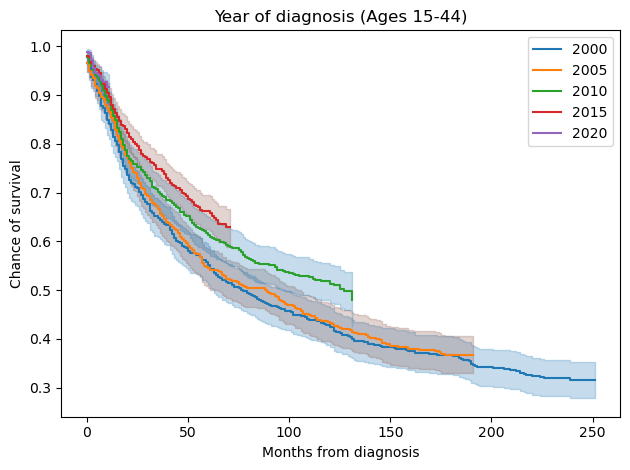

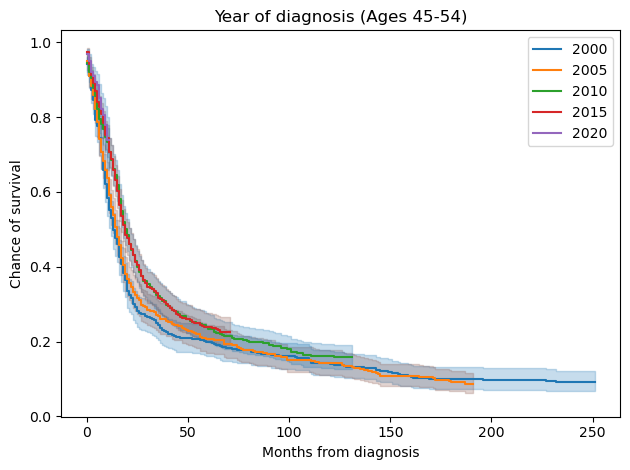

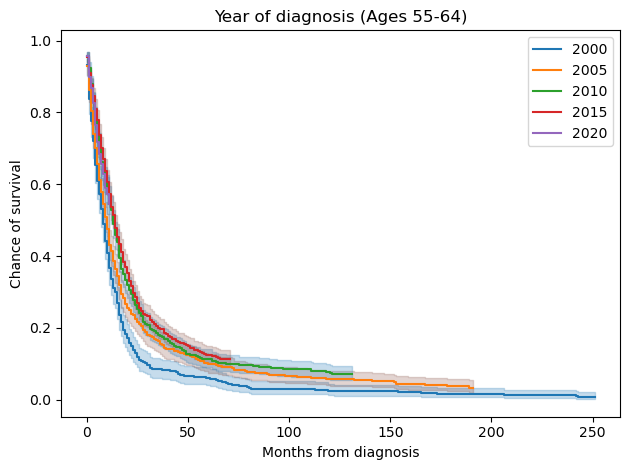

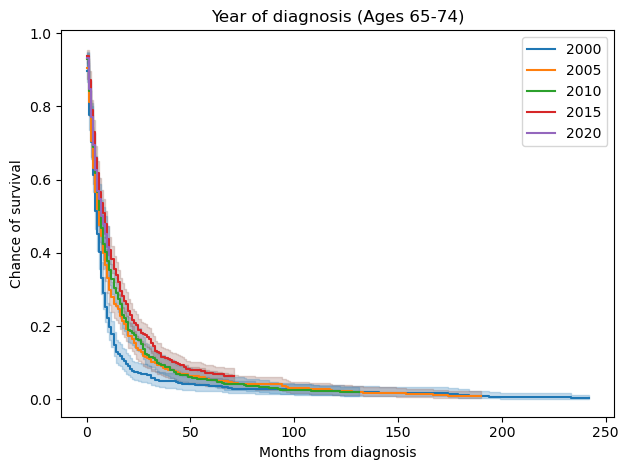

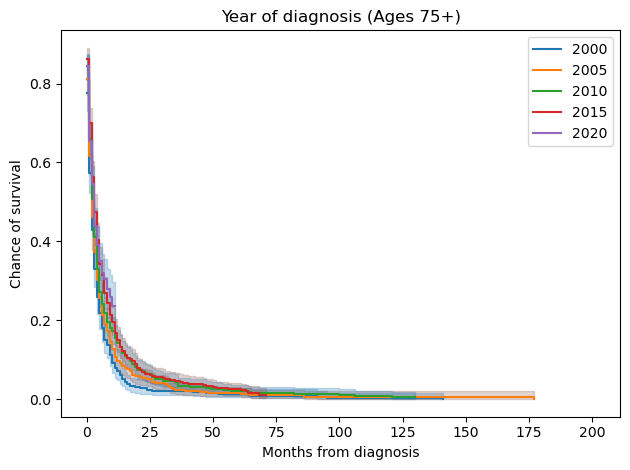

In [40]:
data_copy = data.copy(deep=True)
data_copy['Glioblastoma diagnosis'] = data['SEER Brain and CNS Recode'] == '1.1.2 Glioblastoma'

X_train_copy = X_train.copy(deep=True)
X_train_copy['Glioblastoma diagnosis'] = X_train_copy['SEER Brain and CNS Recode'] == '1.1.2 Glioblastoma'

legend_labels = [str(year) for year in range(2000, 2021, 5)]
plot_titles = [
    'Year of diagnosis (Ages 15-44)',
    'Year of diagnosis (Ages 45-54)',
    'Year of diagnosis (Ages 55-64)',
    'Year of diagnosis (Ages 65-74)',
    'Year of diagnosis (Ages 75+)',
]
plots = []
for i, (title,(name, grouped_df)) in enumerate(zip(plot_titles,X_train_copy.join(y_train).groupby('Age standard for survival'))):
    X_train_grouped = grouped_df.drop(["Event indicator", "Survival months"], axis="columns")
    y_train_grouped = grouped_df[["Event indicator", "Survival months"]]
    
    ax = plot_km_curve(X_train_grouped, y_train_grouped, stratify_class='Year of diagnosis')
    labels_to_keep = [str(year) for year in range(2000, 2021, 5)]
    tab_colors = plt.get_cmap('tab10').colors

    lines = ax.get_lines()
    lines_to_keep = [line for line in lines if line.get_label() in labels_to_keep]
    for line in lines:
        if line.get_label() not in labels_to_keep:
            line.remove()

    collections = ax.collections
    collections_to_keep = []
    for j, line in enumerate(lines):
        if line.get_label() in labels_to_keep:
            collections_to_keep.append(collections[j])  # Adjust the index for multiple collections per line
    for collection in collections:
        if collection not in collections_to_keep:
            collection.remove()
            
    for line, color in zip(lines_to_keep, tab_colors):
        line.set_color(color)

    ax.legend(handles=lines_to_keep)
    manually_set_legend_labels(ax, legend_labels)
    ax.set_title(title)
    fig = ax.get_figure()
    fig.tight_layout()
    fig.savefig(f'reports/figures/km_curve_year_of_diagnosis_age_{i}.pdf')

##### Score the final model

In [41]:
from lifelines.utils import concordance_index

# Transform the test data
X_test_trans = pipeline.transform(X_test)
dd_test_trans = X_test_trans.join(y_test)

# Score it
cindex_test = concordance_index(
    dd_test_trans["Survival months"], 
    -cph_best.predict_partial_hazard(dd_test_trans), 
    dd_test_trans["Event indicator"]
)

print('Test data scores:')
print(f'Concordance index: {cindex_test}')

Test data scores:
Concordance index: 0.7260358532878791
